## Importing all necessary libraries

In [20]:
!pip install scikit-learn-intelex ## for x86 only

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import MiniBatchKMeans

from sklearn.svm import SVC
import cv2

from skimage.feature import hog
from cv2 import HOGDescriptor

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
## If your CPU Intel, you may use this to speed up training process

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

## Reading Data and basic Feature Extraction

In [2]:
def read_data(mode="train", p=0.2, seed=None):
    """
    Read the training/testing files and return the input data and labels.

    Parameters:
    ----------
    mode (str): 'train' or 'test' to read the training or testing data.
    p (float): fraction of the data to read. Useful for debugging.
    seed (int): random seed to use for reproducibility.

    Returns:
    -------
    X (np.array): input data
    y (np.array): labels
    """
    if mode == "train" or mode == "test":
        data = pd.read_csv('train.csv')
        mode = "train"
    elif mode == "predict":
        data = pd.read_csv('test.csv')
        mode = "test"
    else:
        raise ValueError("mode must be 'train' or 'test' or 'predict'")

    if mode != "test":
        if seed is None:data = data.sample(frac=p)
        else: data = data.sample(frac=p, random_state=seed)

    X = data['im_name'].apply(lambda filename: np.asarray(Image.open(f"{mode}_ims/{filename}"))).values
    y = data['label'].values
    X = np.stack(X).reshape(-1, 32*32*3)

    return X, y

In [3]:
def predict_data(predictedLabels, fp='test.csv'):
    """
    Writes and predicts the testing files.

    Parameters:
    ----------
    predictedLabels (np.array): predicted labels for the testing data.
    fp (str): filepath to write the predicted labels.

    Returns:
    -------
    None
    """
    data = pd.read_csv('test.csv')
    data['label'] = predictedLabels
    data.to_csv(fp, index=False)

In [4]:
trainData, trainLabels = read_data("train", p=1, seed=69)
trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=69)
print([sum(trainLabels == i) for i in range(10)])
trainData.shape, trainLabels.shape, testData.shape, testLabels.shape

[4017, 3973, 4033, 4009, 3960, 3992, 3984, 4007, 4069, 3956]


((40000, 3072), (40000,), (10000, 3072), (10000,))

In [5]:
predictData, predictLabels = read_data("predict", p=1)
predictData.shape, predictLabels.shape

((10000, 3072), (10000,))

In [8]:
def hog_features(data, visualize=False, type='cv2', inputShape=(32, 32, 3), dtype='int'):
    assert type in ['sklearn', 'cv2'], "type must be 'sklearn' or 'cv2'"
    if data.ndim == 1: data = data.reshape(1, -1)
    data = data.reshape(-1, *inputShape)
    if dtype == 'float':
        data = ((data - data.min())/(data.max() - data.min()) * 255).astype(np.uint8)
    if type == 'sklearn':
        _hog_kwargs = {
            "block_norm": 'L2-Hys',
            "orientations": 9,
            "pixels_per_cell": (8, 8),
            "cells_per_block": (2, 2),
            "channel_axis": -1
        }
        if visualize: 
            _hogs = [hog(img.reshape(32, 32, 3), **_hog_kwargs, visualize=True) for img in data]
            _hogFeatures = np.array([_hog[0] for _hog in _hogs])
            _hogImgs = np.array([_hog[1] for _hog in _hogs])
            return _hogFeatures, _hogImgs
        else:
            return np.array([hog(img, **_hog_kwargs) for img in data])
    else:
        assert visualize == False, "visualize is not supported for type='cv2'"
        # Following params is found to be optimal for CIFAR-10 dataset
        _hog_kwargs = {
            "_winSize": (32, 32),
            "_blockSize": (12, 12),
            "_blockStride": (4, 4),
            "_cellSize": (4, 4),
            "_nbins": 10,
            "_derivAperture": 1,
            "_winSigma": -1,
            "_histogramNormType": 0,
            "_L2HysThreshold": 0.2,
            "_gammaCorrection": True,
            "_nlevels": 64,
            "_signedGradient": True
        }
        _hog = HOGDescriptor(**_hog_kwargs)
        return np.array([_hog.compute(img) for img in data])

In [9]:
trainData_hog = hog_features(trainData)
testData_hog = hog_features(testData)
predictData_hog = hog_features(predictData)
trainData_hog.shape, testData_hog.shape, predictData_hog.shape

((40000, 3240), (10000, 3240), (10000, 3240))

## K-means and whitening Feature Extraction

In [19]:
PATCH_SHAPE = (6, 6)
def mem_str(A):
    return str(A.shape[0]*A.shape[1]*8/(1024*1024*1024))+'GB' # Currently using float64, shd change to float32 later

In [20]:
def patchStandardize(patches):
    """
    Standardizes patches by P_norm = (P - mean)/sqrt(var + 10).
    """
    patches *= 255
    patches -= patches.mean(axis=1, keepdims=True)
    _var = patches.var(axis=1, keepdims=True) + 10
    patches /= np.sqrt(_var)
    return patches / 255

In [21]:
def getRandomPatches(img, patchSize, k):
    patches = np.empty((img.shape[0] * k, patchSize[0] * patchSize[1] * 3))
    img_samples = np.random.randint(0, img.shape[0], img.shape[0] * k)
    row_samples = np.random.randint(0, img.shape[1] - patchSize[0] + 1, img.shape[0] * k)
    col_samples = np.random.randint(0, img.shape[2] - patchSize[1] + 1, img.shape[0] * k)
    for i, (imgIdx, rowIdx, colIdx) in enumerate(zip(img_samples, row_samples, col_samples)):
        patches[i] = img[imgIdx, rowIdx:rowIdx+patchSize[0], colIdx:colIdx+patchSize[1]].ravel()
    return patches

In [22]:
def enchanceImg(img):
    _width = int(np.sqrt(img.shape[1] / 3))
    img = img.reshape(_width, _width, 3)
    return (img - img.min())/(img.max() - img.min())

In [23]:
class Whiten():
    def __init__(self, eps=1e-2):
        self.eps = eps
        self.mean = None
        self.W = None
    def zca(self, A):
        """
        We aim to find a linear transformation W of X, such that the cov() on the transformed result of X will be diagonal. 
        We add two more restrictions:
        1. The co-variance result should be close to the identity (diagnoal restricted to 1's). 
        2. W should be symetric W = W.T
        with these restirctions, the math expression can be found at : (see the formula development at: page 48 at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)
        """
        U, S, V = np.linalg.svd(A.T @ A / A.shape[1] , full_matrices=True)
        self.W = U @ np.diag(1.0/np.sqrt(S + self.eps)) @ U.T
        return np.dot(A, self.W)
    def fit_transform(self, X):
        self.mean = np.mean(X, axis=0)
        return self.zca(X - self.mean)
    def transform(self, X):
        return (X - self.mean) @ self.W

In [24]:
from sklearn.feature_extraction import image

class KMeansEmbedding():
    def __init__(self, k, seed=None):
        self.k = k
        self.seed = seed
        self.kmeans = MiniBatchKMeans(n_clusters=k, n_init='auto', random_state=seed)
        self.batchSize = 1000
        self.patchSize = PATCH_SHAPE
        self.poolShape = (2, 2)
        self.patchExtractor = image.PatchExtractor(patch_size=self.patchSize,random_state=seed)
    def partial_fit(self, X):
        self.kmeans.partial_fit(X)
    def _transform(self, X):
        distances = self.kmeans.transform(X)
        embedding = np.clip(distances.mean(axis=1, keepdims=True) - distances, 0, None)
        return embedding
    def transform(self, X, whitener):
        embedding = np.zeros((X.shape[0], self.poolShape[0]*self.poolShape[1]*self.k))
        for imgIdx in range(0, X.shape[0], self.batchSize):
            _X = X[imgIdx:imgIdx+self.batchSize]
            poolZoneShape = ((_X.shape[1]-self.patchSize[0]+1)//self.poolShape[0], (_X.shape[2]-self.patchSize[1]+1)//self.poolShape[1])
            zone = 0
            for zone_x in range(0, self.poolShape[0]*poolZoneShape[0], poolZoneShape[0]):
                for zone_y in range(0, self.poolShape[1]*poolZoneShape[1], poolZoneShape[1]):
                    patches = self.patchExtractor.transform(_X[:, zone_x:zone_x+poolZoneShape[0]+self.patchSize[0]-1, zone_y:zone_y+poolZoneShape[1]+self.patchSize[1]-1])
                    patches = patches.reshape(patches.shape[0], -1)
                    patches = patchStandardize(patches)
                    patches = whitener.transform(patches)
                    embedding[imgIdx:imgIdx+self.batchSize, zone*self.k:(zone+1)*self.k] = self._transform(patches).reshape(_X.shape[0], int(patches.shape[0]/_X.shape[0]), self.k).sum(axis=1)
                    zone += 1
        return embedding

In [25]:
class LDA_encoder():
    def __init__(self, ndim):
        self.ndim = ndim
        self._lda = LinearDiscriminantAnalysis(n_components=ndim)
        self.classCenters = None
    def fit(self, X, y):
        _X = self._lda.fit_transform(X, y)
        self.classCenters = np.array([np.mean(_X[y == i], axis=0) for i in np.unique(y)])
    def encode(self, X):
        return 1/np.array([np.linalg.norm(self._lda.transform(X) - center, axis=1) for center in self.classCenters]).T
    def predict(self, X, prob=False):
        _X = self._lda.transform(X)
        if prob:
            return softmax(1/np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T)
        else:
            return np.argmin(np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T, axis=1)

In [26]:
kmeansEmbedding = KMeansEmbedding(4000, seed=69)
whitener = Whiten()

Num of iters = 50
Total Patches = 40000000
Features per step per image = 20
Each iter requires 0.6437 GB of memory
Before Whitening


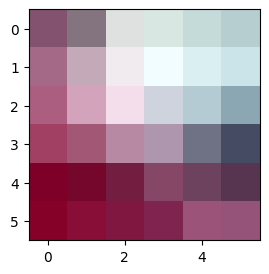

After Whitening


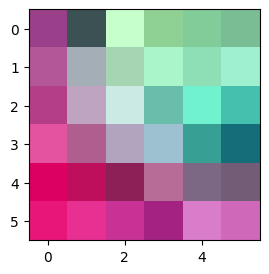

Iteration 1/50 done
Iteration 2/50 done
Iteration 3/50 done
Iteration 4/50 done
Iteration 5/50 done
Iteration 6/50 done
Iteration 7/50 done
Iteration 8/50 done
Iteration 9/50 done
Iteration 10/50 done
Iteration 11/50 done
Iteration 12/50 done
Iteration 13/50 done
Iteration 14/50 done
Iteration 15/50 done
Iteration 16/50 done
Iteration 17/50 done
Iteration 18/50 done
Iteration 19/50 done
Iteration 20/50 done
Iteration 21/50 done
Iteration 22/50 done
Iteration 23/50 done
Iteration 24/50 done
Iteration 25/50 done
Iteration 26/50 done
Iteration 27/50 done
Iteration 28/50 done
Iteration 29/50 done
Iteration 30/50 done
Iteration 31/50 done
Iteration 32/50 done
Iteration 33/50 done
Iteration 34/50 done
Iteration 35/50 done
Iteration 36/50 done
Iteration 37/50 done
Iteration 38/50 done
Iteration 39/50 done
Iteration 40/50 done
Iteration 41/50 done
Iteration 42/50 done
Iteration 43/50 done
Iteration 44/50 done
Iteration 45/50 done
Iteration 46/50 done
Iteration 47/50 done
Iteration 48/50 done
I

In [27]:
whitenerBatch = 40000*100//5

totPatches = len(trainData) * 1000
totSteps = int(np.ceil(totPatches/whitenerBatch))
featuresPerStepPerImg = int(np.ceil(totPatches/totSteps/len(trainData)))
print(f"Num of iters = {totSteps}\nTotal Patches = {totPatches}\nFeatures per step per image = {featuresPerStepPerImg}\nEach iter requires {featuresPerStepPerImg*len(trainData)*PATCH_SHAPE[0]*PATCH_SHAPE[1]*3*8/(1024*1024*1024):.4f} GB of memory")
for i in range(totSteps):
    patches = getRandomPatches(trainData.reshape(-1, 32, 32, 3), PATCH_SHAPE, featuresPerStepPerImg)
    patches = patchStandardize(patches)
    if i == 0:
        print("Before Whitening")
        plt.figure(figsize=(3, 3))
        plt.imshow(enchanceImg(patches[:1]))
        plt.show()
        patches = whitener.fit_transform(patches.reshape(-1, PATCH_SHAPE[0]*PATCH_SHAPE[1]*3))
        print("After Whitening")
        plt.figure(figsize=(3, 3))
        plt.imshow(enchanceImg(patches[:1]))
        plt.show()
    else:
        patches = whitener.transform(patches.reshape(-1, PATCH_SHAPE[0]*PATCH_SHAPE[1]*3))
    kmeansEmbedding.partial_fit(patches)
    print(f"Iteration {i+1}/{totSteps} done")

In [28]:
trainData_Embedding = kmeansEmbedding.transform(trainData.reshape(-1, 32, 32, 3), whitener)
testData_Embedding = kmeansEmbedding.transform(testData.reshape(-1, 32, 32, 3), whitener)
predictData_Embedding = kmeansEmbedding.transform(predictData.reshape(-1, 32, 32, 3), whitener)
trainData_Embedding.shape, testData_Embedding.shape, predictData_Embedding.shape

((40000, 16000), (10000, 16000), (10000, 16000))

In [36]:
# save
np.save('kmeans4000_embeds/trainData_Embedding', trainData_Embedding)
np.save('kmeans4000_embeds/testData_Embedding', testData_Embedding)
np.save('kmeans4000_embeds/predictData_Embedding', predictData_Embedding)
# and labels
np.save('kmeans4000_embeds/trainLabels', trainLabels)
np.save('kmeans4000_embeds/testLabels', testLabels)

In [ ]:
lda = LDA_encoder(ndim=9)
lda.fit(trainData_Embedding, trainLabels)

In [ ]:
trainData_Embedding_lda = np.hstack([trainData_Embedding, lda.encode(trainData_Embedding)])
testData_Embedding_lda = np.hstack([testData_Embedding, lda.encode(testData_Embedding)])
predictData_Embedding_lda = np.hstack([predictData_Embedding, lda.encode(predictData_Embedding)])
trainData_Embedding_lda.shape, testData_Embedding_lda.shape, predictData_Embedding_lda.shape

((40000, 410), (10000, 410), (10000, 410))

In [281]:
def mask(X, p=0.2):
    mask = np.random.rand(X.shape[0], X.shape[1]) > p
    return X * mask

In [282]:
trainData_Embedding_masked = mask(trainData_Embedding, p=0)
testData_Embedding_masked = mask(testData_Embedding, p=0)
predictData_Embedding_masked = mask(predictData_Embedding, p=0)
trainData_Embedding_masked.shape, testData_Embedding_masked.shape, predictData_Embedding_masked.shape

((40000, 3200), (10000, 3200), (10000, 3200))

In [283]:
trainData_Embedding[0, :10]

array([0.22991468, 1.43338879, 1.77013269, 1.81065524, 0.76901093,
       1.41512245, 0.72819399, 1.00643477, 0.86055008, 1.20136789])

In [29]:
from sklearn import svm
from liblinear.liblinearutil import train, predict, save_model, load_model

def computeTestAcc(p, trainData, trainLabels, testData, testLabels):
    svm_ft = train(trainLabels, trainData, f'-c {10**p} -s 2')
    return predict(testLabels, testData, svm_ft)[1][0]

In [30]:
a, b = -1, 1
precision = 5e-3
phi = (np.sqrt(5)-1)/2
subset = 10000

l = a + (1-phi)*(b-a)
r = a + phi*(b-a)
fl = computeTestAcc(l, trainData_Embedding[:subset], trainLabels[:subset], testData_Embedding, testLabels)
fr = computeTestAcc(r, trainData_Embedding[:subset], trainLabels[:subset], testData_Embedding, testLabels)

iter = 0

print(f"Initializations, intial interval: [{a:.4f}, {b:.4f}], error: {b-a:.4f}, optimal C: {10**((b+a)/2):.4f} +/- {10**b-10**((b+a)/2):.4f}")

while b - a > precision:
    if fl < fr:
        a = l
        l = r
        fl = fr
        r = a + phi*(b-a)
        fr = computeTestAcc(r, trainData_Embedding[:subset], trainLabels[:subset], testData_Embedding, testLabels)
    else:
        b = r
        r = l
        fr = fl
        l = a + (1-phi)*(b-a)
        fl = computeTestAcc(l, trainData_Embedding[:subset], trainLabels[:subset], testData_Embedding, testLabels)
    iter += 1
    print(f"Iteration {iter}, interval: [{a:.4f}, {b:.4f}], error: {b-a:.4f}, optimal C: {10**((b+a)/2):.4f} +/- {10**b-10**((b+a)/2):.4f}, accuracy: {{left: {fl}, right: {fr}}}")

optimalC = 10**((b+a)/2)
print(f"Optimal C: {optimalC:.4f} +/- {10**b-optimalC:.4f}")

Accuracy = 68.68% (6868/10000) (classification)
Accuracy = 68.09% (6809/10000) (classification)
Initializations, intial interval: [-1.0000, 1.0000], error: 2.0000, optimal C: 1.0000 +/- 9.0000
Accuracy = 68.65% (6865/10000) (classification)
Iteration 1, interval: [-1.0000, 0.2361], error: 1.2361, optimal C: 0.4150 +/- 1.3072, accuracy: {left: 68.65, right: 68.67999999999999}
Accuracy = 68.81% (6881/10000) (classification)
Iteration 2, interval: [-0.5279, 0.2361], error: 0.7639, optimal C: 0.7147 +/- 1.0075, accuracy: {left: 68.67999999999999, right: 68.81}
Accuracy = 68.46% (6846/10000) (classification)
Iteration 3, interval: [-0.2361, 0.2361], error: 0.4721, optimal C: 1.0000 +/- 0.7221, accuracy: {left: 68.81, right: 68.46}
Accuracy = 68.84% (6884/10000) (classification)
Iteration 4, interval: [-0.2361, 0.0557], error: 0.2918, optimal C: 0.8125 +/- 0.3244, accuracy: {left: 68.84, right: 68.81}
Accuracy = 69.06% (6906/10000) (classification)
Iteration 5, interval: [-0.2361, -0.0557], 

In [31]:
svm = train(trainLabels, trainData_Embedding, f'-c {optimalC} -s 2')

In [34]:
test_pred, test_acc, test_val = predict(testLabels, testData_Embedding, svm)

Accuracy = 74.3% (7430/10000) (classification)


In [ ]:
from sklearn import svm

svm = svm.LinearSVC(C=optimalC, dual=False, random_state=69)
svm.fit(trainData_Embedding, trainLabels)

LinearSVC(C=0.11755551787634247, dual=False, random_state=69)

In [ ]:
test_pred = svm.predict(testData_Embedding_masked)
(test_pred == testLabels).mean()

0.749

In [ ]:
# erm slow
train_pred = svm.predict(trainData_Embedding_masked)
(train_pred == trainLabels).mean()

0.8325

In [33]:
cm = confusion_matrix(testLabels, test_pred)
plt.imshow(cm, cmap='Blues')
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black' if cm[i, j] < cm.max()/2 else 'white')
plt.xlabel("Prediction")
plt.ylabel("True")

NameError: name 'test_pred' is not defined

In [165]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [226]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(input_dim, 10)
    def forward(self, X):
        X = self.lr(X)
        return X
    def train(self, trainData, trainLabels, testData, testLabels, mode='iterate'):
        epochs = 500
        optimizer = optim.Adam(self.parameters(), lr=7e-4)
        criterion = nn.CrossEntropyLoss()

        trainData_dataset = data.TensorDataset(trainData, trainLabels)
        trainData_dataloader = data.DataLoader(trainData_dataset, batch_size=128, shuffle=True)

        for epoch in range(epochs):
            tot_loss = 0
            for X, y in trainData_dataloader:
                outputs = self(X)
                loss = criterion(outputs, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                tot_loss += loss.item()
            tot_loss /= len(trainData_dataloader)
            if (epoch+1) % 5 == 0:
                train_acc = (self(trainData).argmax(axis=1) == trainLabels).to(dtype=torch.float32).mean().item()
                test_acc = (self(testData).argmax(axis=1) == testLabels).to(dtype=torch.float32).mean().item()
                print(f"Epoch {epoch+1}/{epochs}, Loss: {tot_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
            if epochs == 100:
                for param in optimizer.param_groups:
                    param['lr'] = 1e-4
            if epochs == 200:
                for param in optimizer.param_groups:
                    param['lr'] = 5e-5

In [227]:
lr = LogisticRegression(trainData_Embedding.shape[1])

In [228]:
trainData_Embedding_tensor = torch.tensor(trainData_Embedding, dtype=torch.float32)
trainLabels_tensor = torch.tensor(trainLabels, dtype=torch.long)
testData_Embedding_tensor = torch.tensor(testData_Embedding, dtype=torch.float32)
testLabels_tensor = torch.tensor(testLabels, dtype=torch.long)
trainData_Embedding_tensor.shape, trainLabels_tensor.shape, testData_Embedding_tensor.shape, testLabels_tensor.shape

(torch.Size([40000, 3200]),
 torch.Size([40000]),
 torch.Size([10000, 3200]),
 torch.Size([10000]))

In [229]:
lr.train(trainData_Embedding_tensor, trainLabels_tensor, testData_Embedding_tensor, testLabels_tensor)

Epoch 5/500, Loss: 1.1179, Train Acc: 0.6227, Test Acc: 0.6052
Epoch 10/500, Loss: 1.0368, Train Acc: 0.6472, Test Acc: 0.6300
Epoch 15/500, Loss: 0.9950, Train Acc: 0.6599, Test Acc: 0.6346
Epoch 20/500, Loss: 0.9662, Train Acc: 0.6475, Test Acc: 0.6262
Epoch 25/500, Loss: 0.9391, Train Acc: 0.6732, Test Acc: 0.6496
Epoch 30/500, Loss: 0.9190, Train Acc: 0.6940, Test Acc: 0.6638
Epoch 35/500, Loss: 0.9012, Train Acc: 0.6963, Test Acc: 0.6701
Epoch 40/500, Loss: 0.8967, Train Acc: 0.6996, Test Acc: 0.6686
Epoch 45/500, Loss: 0.8801, Train Acc: 0.7034, Test Acc: 0.6704
Epoch 50/500, Loss: 0.8772, Train Acc: 0.7054, Test Acc: 0.6733
Epoch 55/500, Loss: 0.8606, Train Acc: 0.7068, Test Acc: 0.6734
Epoch 60/500, Loss: 0.8487, Train Acc: 0.7067, Test Acc: 0.6812
Epoch 65/500, Loss: 0.8363, Train Acc: 0.7138, Test Acc: 0.6825
Epoch 70/500, Loss: 0.8351, Train Acc: 0.7103, Test Acc: 0.6799
Epoch 75/500, Loss: 0.8294, Train Acc: 0.7121, Test Acc: 0.6763
Epoch 80/500, Loss: 0.8157, Train Acc: 0.